In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import os
import hydra
from hydra import initialize_config_module, initialize, compose
from hydra.core.global_hydra import GlobalHydra
import sys

# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.float16).__enter__()
 
if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [2]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
 
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0,0,1,0.4), thickness=1) 
 
    ax.imshow(img)

In [3]:
from PIL import Image
import numpy as np
import cv2

scale_percent = 30  # Resize to 50% of the original size

# Load the image
image_bgr = cv2.imread('datasets/aalesund/1504201/201.jpg')

# Calculate the new dimensions
width = int(image_bgr.shape[1] * scale_percent / 100)
height = int(image_bgr.shape[0] * scale_percent / 100)
new_dim = (width, height)

# Resize both the BGR and RGB images by percentage
image_bgr = cv2.resize(image_bgr, new_dim, interpolation=cv2.INTER_AREA)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [4]:
import os
import torch
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Move the model to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths to configuration and checkpoint files
config_file_path = "./sam2.1_hiera_l.yaml"  # Config file in root directory
checkpoint_file_path = "./sam2.1_hiera_large.pt"  # Checkpoint file in root directory

# Verify file existence
assert os.path.exists(config_file_path), f"Config file not found at {config_file_path}"
assert os.path.exists(checkpoint_file_path), f"Checkpoint file not found at {checkpoint_file_path}"

# Clear any existing Hydra instances
GlobalHydra.instance().clear()

# Initialize Hydra
with initialize(config_path="."):
    # Now you can call build_sam2
    print("Attempting to initialize the SAM2 model...")
    sam2_model = build_sam2(config_file=config_file_path, ckpt_path=checkpoint_file_path).to(device)

sam2_model.to(device)

# Create mask generator
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=64,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.9,
    stability_score_offset=1.0,
    mask_threshold=0.0,
    box_nms_thresh=1,           
    crop_n_layers=1,
    crop_nms_thresh=0.7,
    crop_overlap_ratio=0.2,        
    crop_n_points_downscale_factor=1,
    point_grids=None,
    min_mask_region_area=0,
    output_mode="binary_mask",
    use_m2m=True,                  
    multimask_output=False
)


print("Model and mask generator initialized successfully.")


/home/siverteh/.local/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()
/tmp/ipykernel_51373/4162925778.py:23: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="."):


Attempting to initialize the SAM2 model...
Model and mask generator initialized successfully.


In [5]:
sam_result = mask_generator.generate(image_rgb)

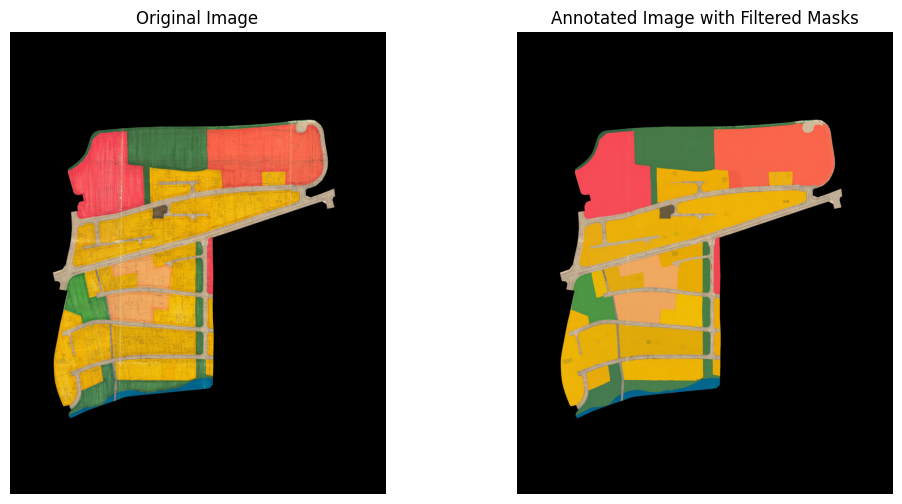

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import mode
import supervision as sv
from supervision.draw.color import Color, ColorPalette

# Assuming `sam_result` and `image_bgr` (BGR format) are pre-loaded and available

# Define function to check if one mask is completely inside another
def is_mask_inside(outer_mask, inner_mask):
    # Check if all True pixels in inner_mask are also True in outer_mask
    return np.all(outer_mask[inner_mask > 0])

# Step 1: Extract masks and compute area for sorting
# Include the index to reference back to `sam_result`
masks_with_areas = [
    (i, mask['segmentation'], np.sum(mask['segmentation']))
    for i, mask in enumerate(sam_result) if np.any(mask['segmentation'])
]

# Sort masks by area (from largest to smallest)
masks_with_areas.sort(key=lambda x: x[2], reverse=True)  # (index, mask, area)

# Set the threshold for the minimum number of contained masks required to remove a mask
contained_mask_threshold = int(0.5 * len(masks_with_areas))

# Identify masks to remove
indices_to_remove = set()

# Loop through masks and remove larger masks that contain multiple smaller masks
for i, (outer_idx, outer_mask, outer_area) in enumerate(masks_with_areas):
    contained_count = 0  # Counter for masks contained within the current outer mask

    for inner_idx, inner_mask, inner_area in masks_with_areas[i+1:]:
        if is_mask_inside(outer_mask, inner_mask):
            contained_count += 1  # Increment count for each contained mask

    # Only mark the larger mask for removal if it contains at least `contained_mask_threshold` smaller masks
    if contained_count >= contained_mask_threshold:
        indices_to_remove.add(outer_idx)

# Filter out the unwanted masks
filtered_masks_with_areas = [
    (idx, mask, area) for idx, mask, area in masks_with_areas if idx not in indices_to_remove
]

# Also remove any masks that cover the entire image (if any)
image_area = image_bgr.shape[0] * image_bgr.shape[1]
filtered_masks_with_areas = [
    (idx, mask, area) for idx, mask, area in filtered_masks_with_areas if area < image_area
]

# Create a filtered sam_result
filtered_sam_result = [sam_result[idx] for idx, _, _ in filtered_masks_with_areas]

# Get the sorted masks
sorted_masks = [mask for _, mask, _ in filtered_masks_with_areas]

# Define custom function to find the mode of an array
def custom_mode(array):
    values, counts = np.unique(array, return_counts=True)
    return values[np.argmax(counts)]

# Function to get the most common color within a masked area
def get_most_common_color(image_bgr, mask):
    mask_area = np.where(mask)
    pixels = image_bgr[mask_area]
    if pixels.size == 0 or pixels.ndim != 2 or pixels.shape[1] != 3:
        return (0, 0, 0)

    # Use custom mode for each channel (BGR order)
    b_mode = int(custom_mode(pixels[:, 0]))
    g_mode = int(custom_mode(pixels[:, 1]))
    r_mode = int(custom_mode(pixels[:, 2]))
    return (b_mode, g_mode, r_mode)  # Increase brightness for visibility

# Generate ColorPalette with BGR colors based on sorted mask order
sorted_mask_colors = [
    Color.from_bgr_tuple(get_most_common_color(image_bgr, mask)) for mask in sorted_masks
]
custom_color_palette = ColorPalette(colors=sorted_mask_colors)

# Convert filtered SAM result to detections and annotate using the sorted colors
detections = sv.Detections.from_sam(sam_result=filtered_sam_result)
mask_annotator = sv.MaskAnnotator(color=custom_color_palette, opacity=0.9)

# Create a custom color lookup array based on sorted colors
custom_color_lookup = np.arange(len(sorted_mask_colors))

try:
    # Annotate the image with the custom color palette in BGR
    annotated_image_with_custom_colors = mask_annotator.annotate(
        scene=image_bgr.copy(),  # Input image in BGR
        detections=detections,
        custom_color_lookup=custom_color_lookup
    )

    # Display the original and annotated images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))  # Convert for display only
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(annotated_image_with_custom_colors, cv2.COLOR_BGR2RGB))  # Convert for display
    plt.title("Annotated Image with Filtered Masks")
    plt.axis("off")

    plt.show()

except AssertionError as ae:
    print(f"Assertion error: {ae}")
except Exception as e:
    print(f"Error during annotation: {e}")


Total polygons extracted before filtering: 148
Total polygons after excluding large masks: 147
Total polygons after filtering: 57


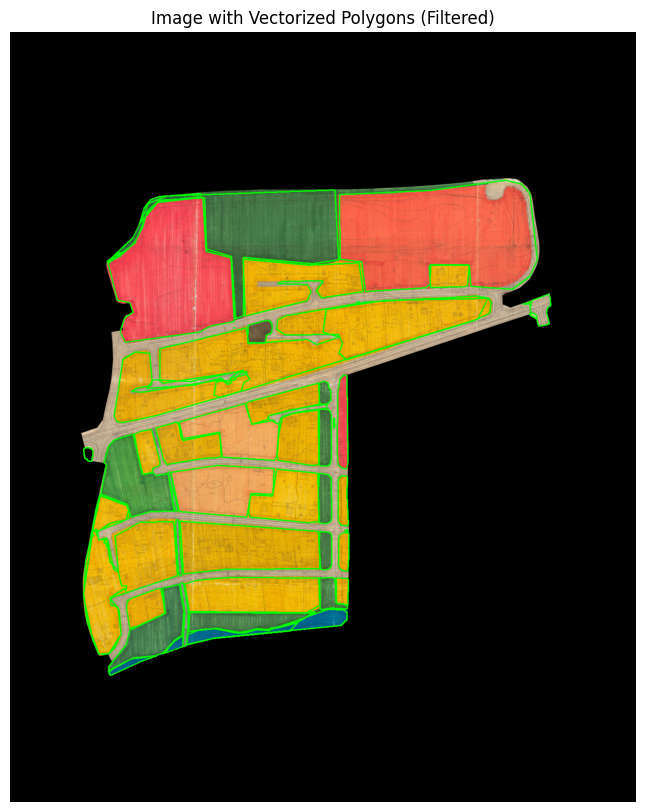

In [7]:
# --- New Cell: Generate and Overlay Vectorized Polygons with Adjusted Filtering ---

import cv2
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

polygons_list = []

# Prepare a copy of the original image for drawing polygons
image_with_polygons = image_bgr.copy()

# Image area
image_area = image_bgr.shape[0] * image_bgr.shape[1]

# List to store polygons with their area
mask_polygons = []

# Loop over each mask in the filtered SAM result
for idx, mask_dict in enumerate(filtered_sam_result):
    mask = mask_dict['segmentation'].astype(np.uint8)  # Ensure mask is in uint8 format

    # Find contours in the mask
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Skip if no contours are found
    if not contours:
        continue

    # Approximate contours to polygons and store them
    for contour in contours:
        # Simplify the contour to reduce the number of points
        epsilon = 0.005 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) >= 3:  # Valid polygon has at least 3 points
            # Reshape the contour array and convert to a list of (x, y) tuples
            coords = approx.reshape(-1, 2)
            polygon = Polygon(coords)
            # Ensure the polygon is valid
            if not polygon.is_valid or polygon.area == 0:
                continue
            # Store the polygon along with its area
            mask_polygons.append({'area': polygon.area, 'polygon': polygon})

# Debug: Print the number of polygons extracted
print(f"Total polygons extracted before filtering: {len(mask_polygons)}")

# Identify and exclude the largest mask if it covers most of the image
# Define a threshold for the maximum allowable area (e.g., 90% of the image area)
max_area_threshold = 0.9 * image_area

# Filter out masks that are too large
mask_polygons = [mp for mp in mask_polygons if mp['area'] < max_area_threshold]

# Debug: Print the number of polygons after excluding large masks
print(f"Total polygons after excluding large masks: {len(mask_polygons)}")

# Function to check if a polygon is mostly within existing polygons
def is_polygon_mostly_within(poly, existing_polys, area_overlap_threshold=0.9):
    for existing_poly in existing_polys:
        intersection_area = poly.intersection(existing_poly).area
        if poly.area == 0:
            continue
        overlap_ratio = intersection_area / poly.area
        if overlap_ratio >= area_overlap_threshold:
            return True
    return False

# Now, filter out smaller polygons that are mostly within larger ones
# Sort polygons by area in descending order
mask_polygons.sort(key=lambda x: x['area'], reverse=True)

# Initialize list to hold the final polygons
filtered_polygons = []

# Process each polygon
for poly_dict in mask_polygons:
    poly = poly_dict['polygon']
    # Exclude the largest mask if it covers most of the image
    if poly.area >= max_area_threshold:
        continue
    if not is_polygon_mostly_within(poly, [d['polygon'] for d in filtered_polygons], area_overlap_threshold=0.95):
        filtered_polygons.append(poly_dict)

# Debug: Print the number of polygons after filtering
print(f"Total polygons after filtering: {len(filtered_polygons)}")

# Draw the filtered polygons on the image
for poly_dict in filtered_polygons:
    poly = poly_dict['polygon']
    # Get the exterior coordinates as integer tuples
    coords = np.array(list(poly.exterior.coords)).astype(np.int32)
    # Draw the polygon on the image
    color = (0, 255, 0)  # Green color for polygons (BGR format)
    cv2.polylines(image_with_polygons, [coords], isClosed=True, color=color, thickness=2)
    # Add to the list of polygons for potential export
    polygons_list.append(poly)

# Display the image with vectorized polygons
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_polygons, cv2.COLOR_BGR2RGB))
plt.title("Image with Vectorized Polygons (Filtered)")
plt.axis("off")
plt.show()
